# 사람의 동작 분류
- 핸드폰 센서 데이터 분류 (GPU 사용 권장)
- 선형 모델, 랜덤포레스트, MLP, CNN 비교

# import

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import zipfile
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import to_categorical
%config InlineBackend.figure_format = 'retina'

# 데이터
- 사람 행동 데이터 다운로드

In [2]:
!curl https://raw.githubusercontent.com/StillWork/data/master/smartphone.zip\
    -o smartphone.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 10.4M    0 12339    0     0  13578      0  0:13:25 --:--:--  0:13:25 13604
 33 10.4M   33 3550k    0     0  2702k      0  0:00:03  0:00:01  0:00:02 2706k
100 10.4M  100 10.4M    0     0  5363k      0  0:00:01  0:00:01 --:--:-- 5370k


In [5]:
# 압축 풀기
with zipfile.ZipFile("smartphone.zip", 'r') as z: 
    print(z.namelist()) 
    z.extractall() 

['smartphone.txt']


## 데이터 전처리

In [7]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone.txt', header=None, names=column_names)
print(df.shape)
df[:3]

(1086475, 6)


,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086475 entries, 0 to 1086474
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1086475 non-null  int64  
 1   activity   1086475 non-null  object 
 2   timestamp  1086475 non-null  int64  
 3   x-axis     1086475 non-null  float64
 4   y-axis     1086475 non-null  float64
 5   z-axis     1086475 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 49.7+ MB


In [10]:
# z-컬럼의 ';'를 삭제하고 문자열 타입을 숫자 타입으로 변경한다 
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].apply(float)
df[:3]

<Axes: >

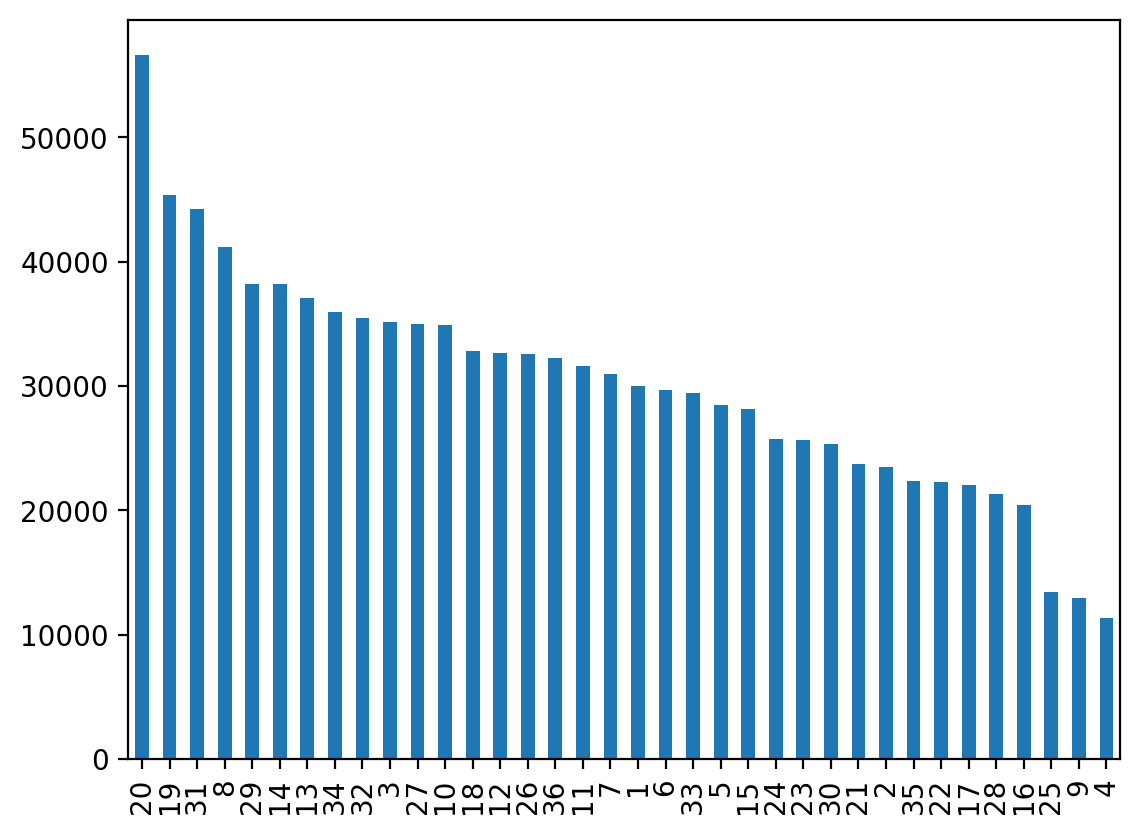

In [12]:
# 사용자별 데이터 수집량 보기
df['user-id'].value_counts().plot(kind='bar')

In [13]:
df["user-id"].nunique()

36

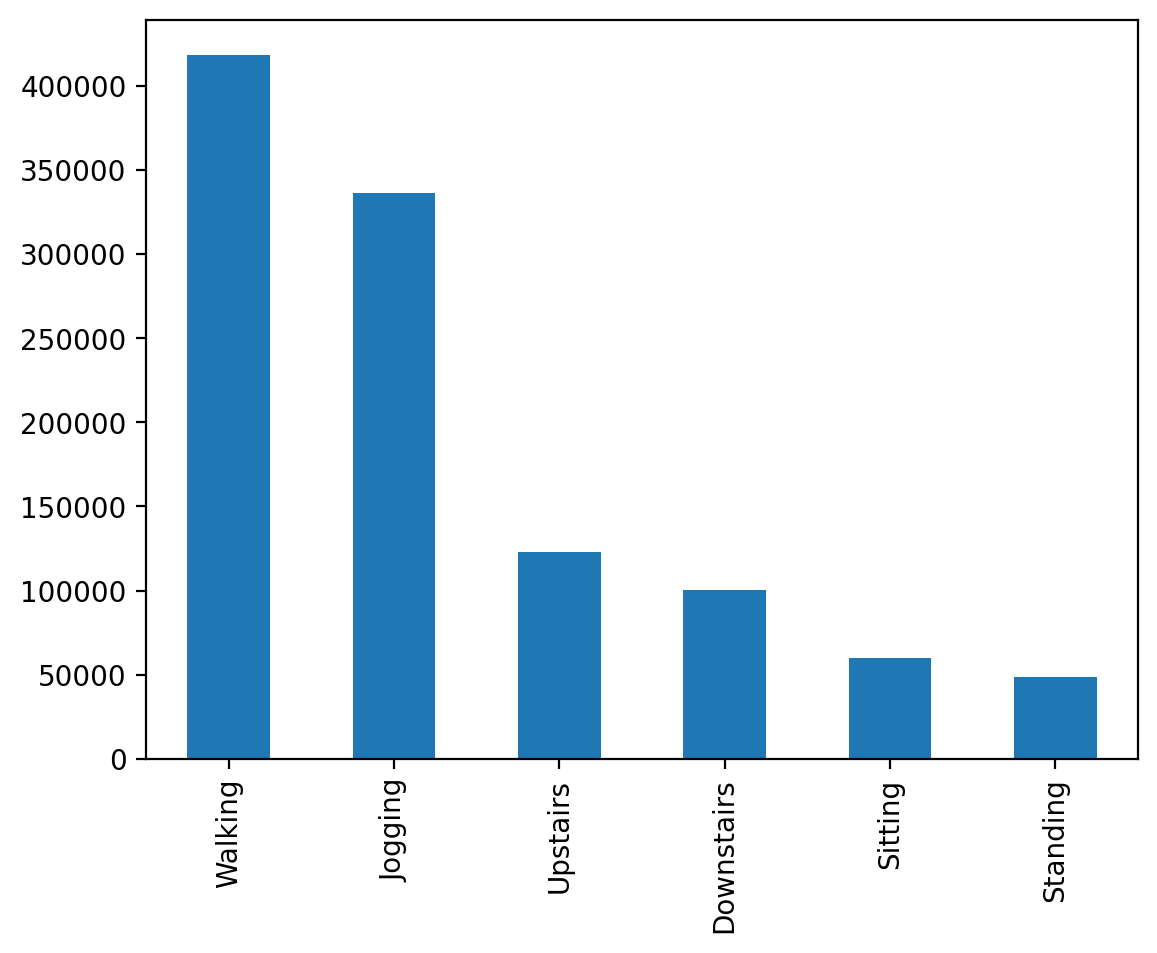

In [14]:
df['activity'].value_counts().plot(kind='bar')
plt.show()

<Axes: >

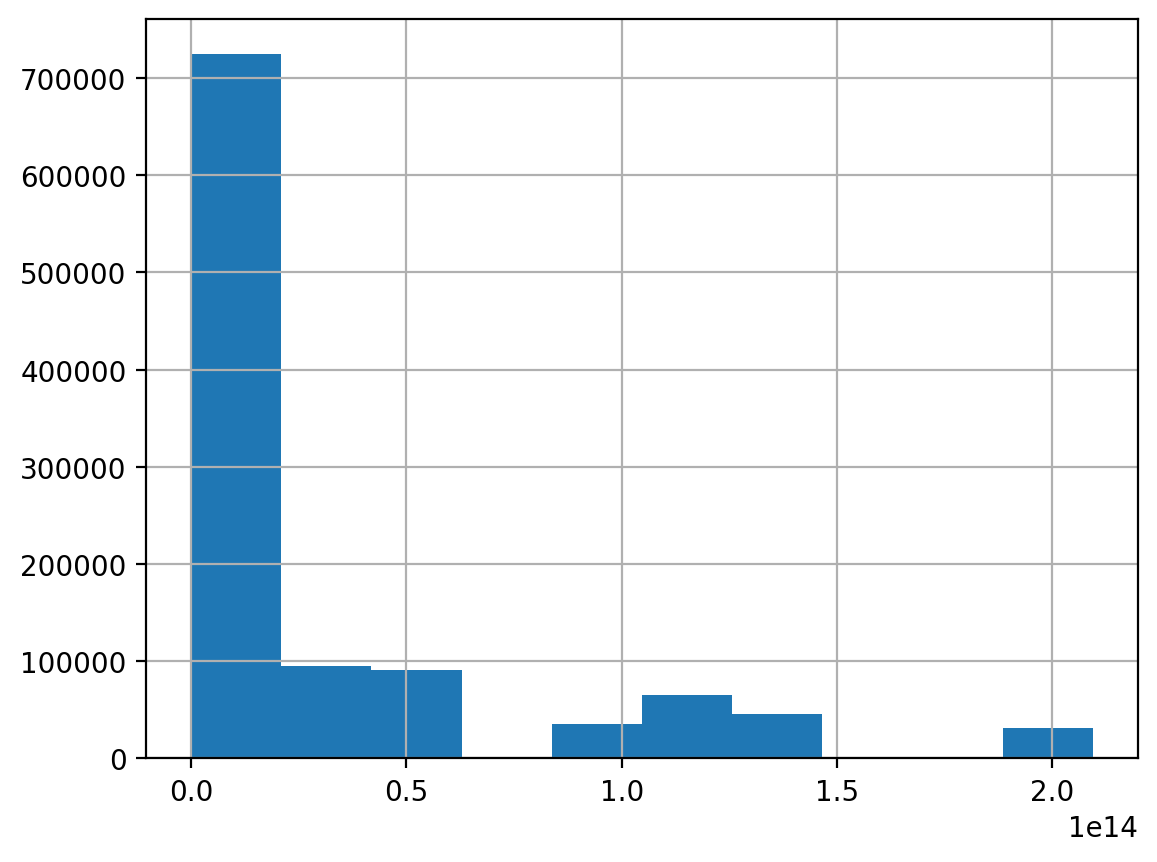

In [15]:
df['timestamp'].hist()

In [16]:
(df['timestamp'] == 0).sum()

12845

In [18]:
# 시각이 0 이거나 음수인 샘플은 제외 (양수인 값만 사용)
print(df.shape)
df = df[df['timestamp'] > 0]
df.shape

(1073630, 6)


(1073630, 6)

## 데이터 시각화

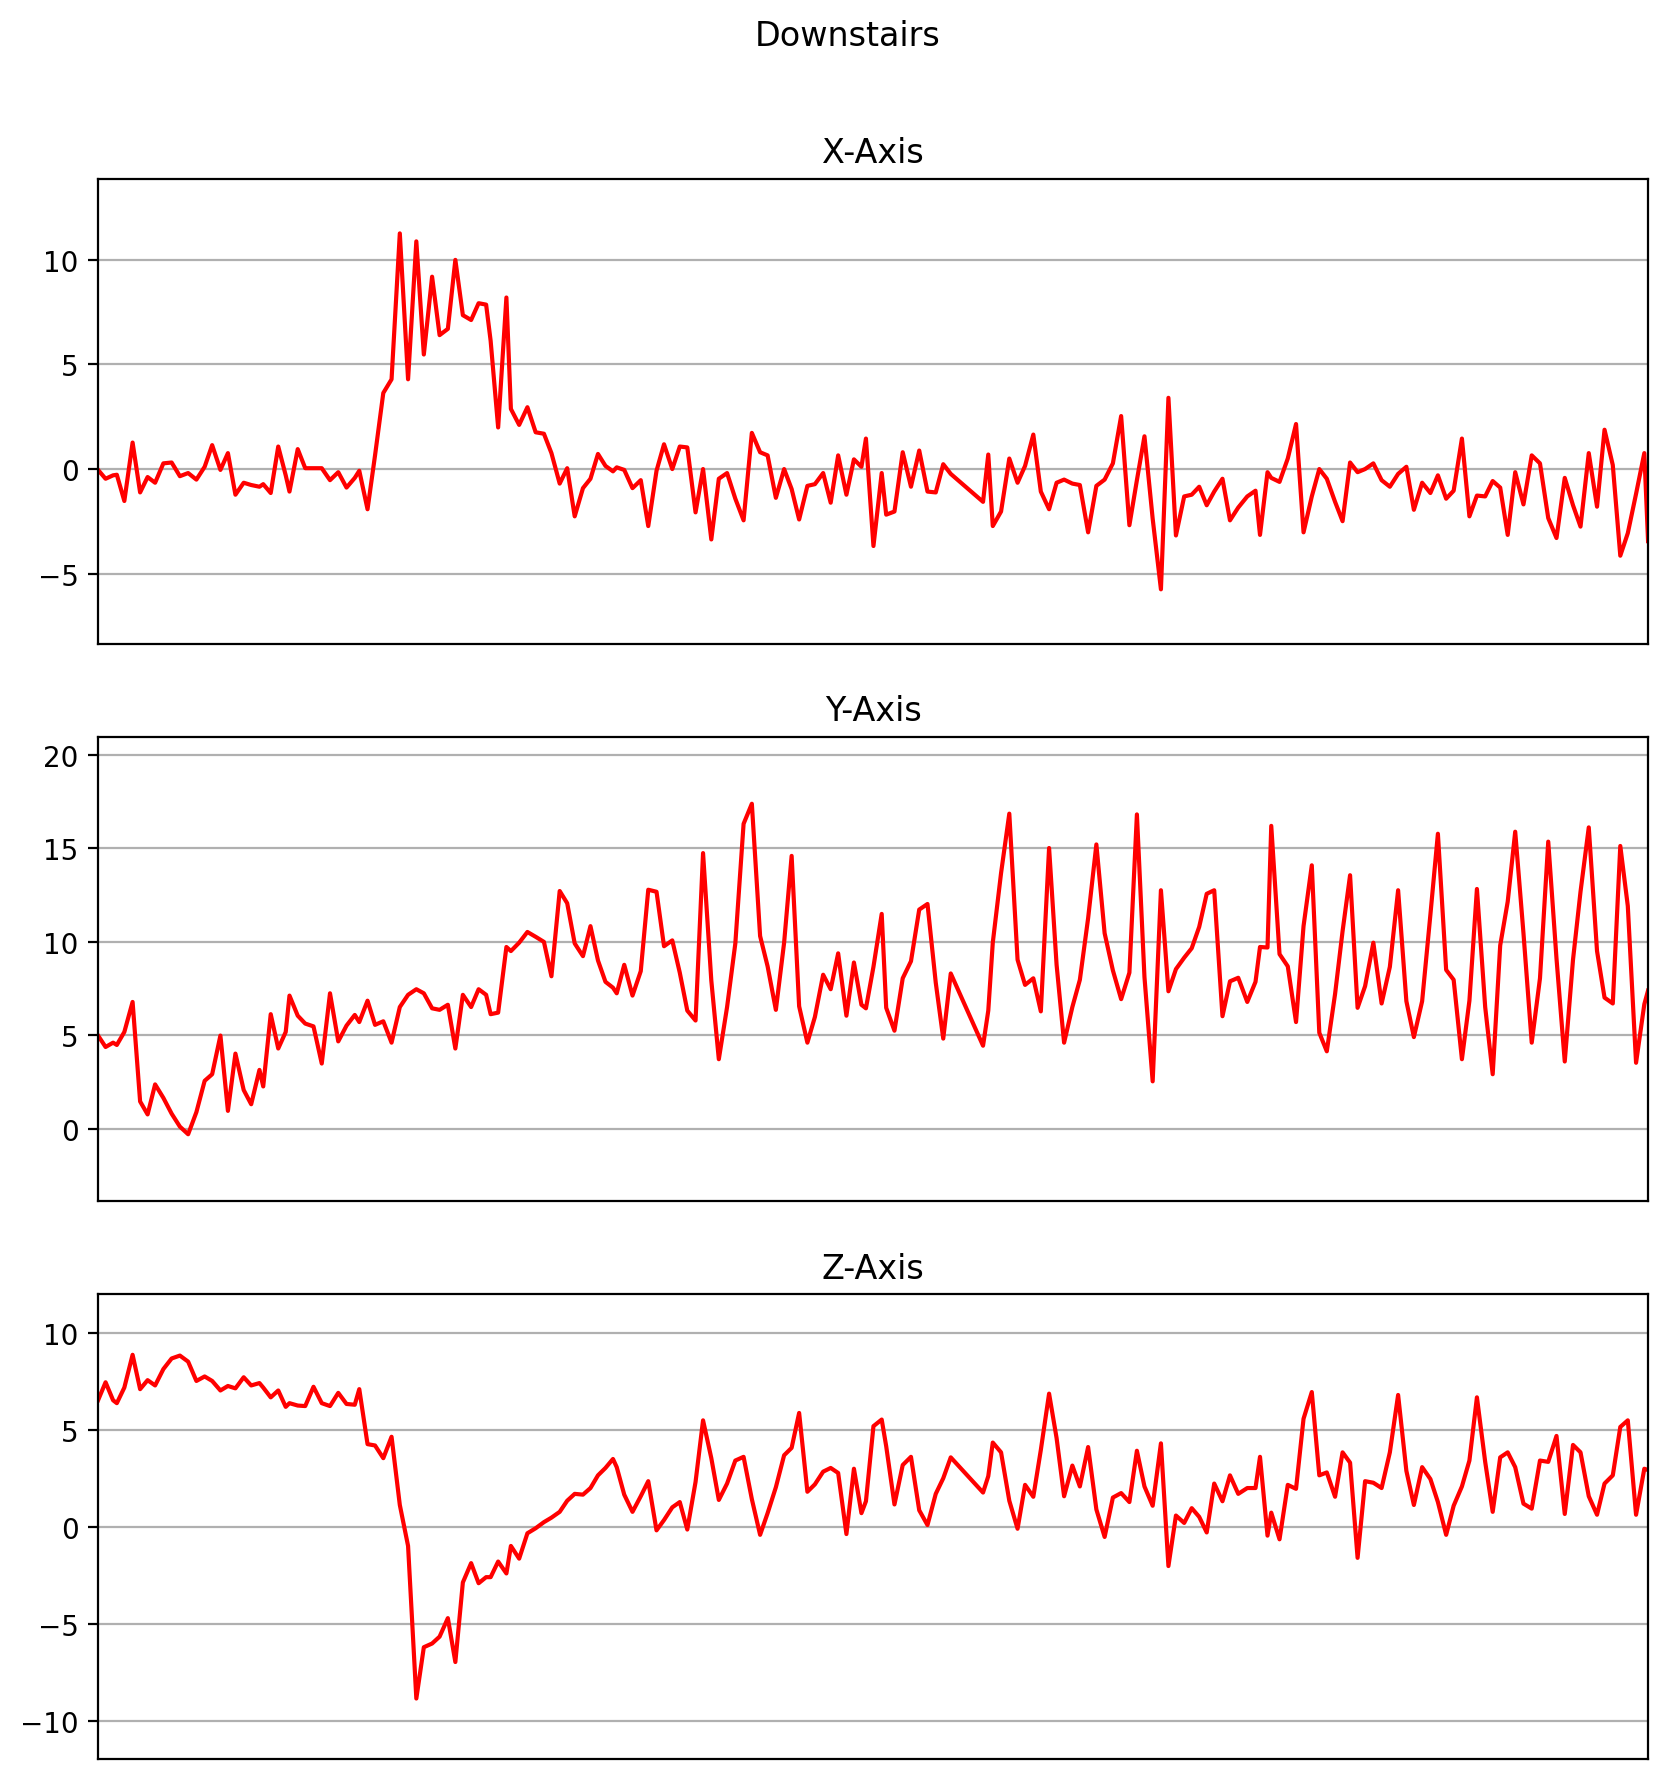

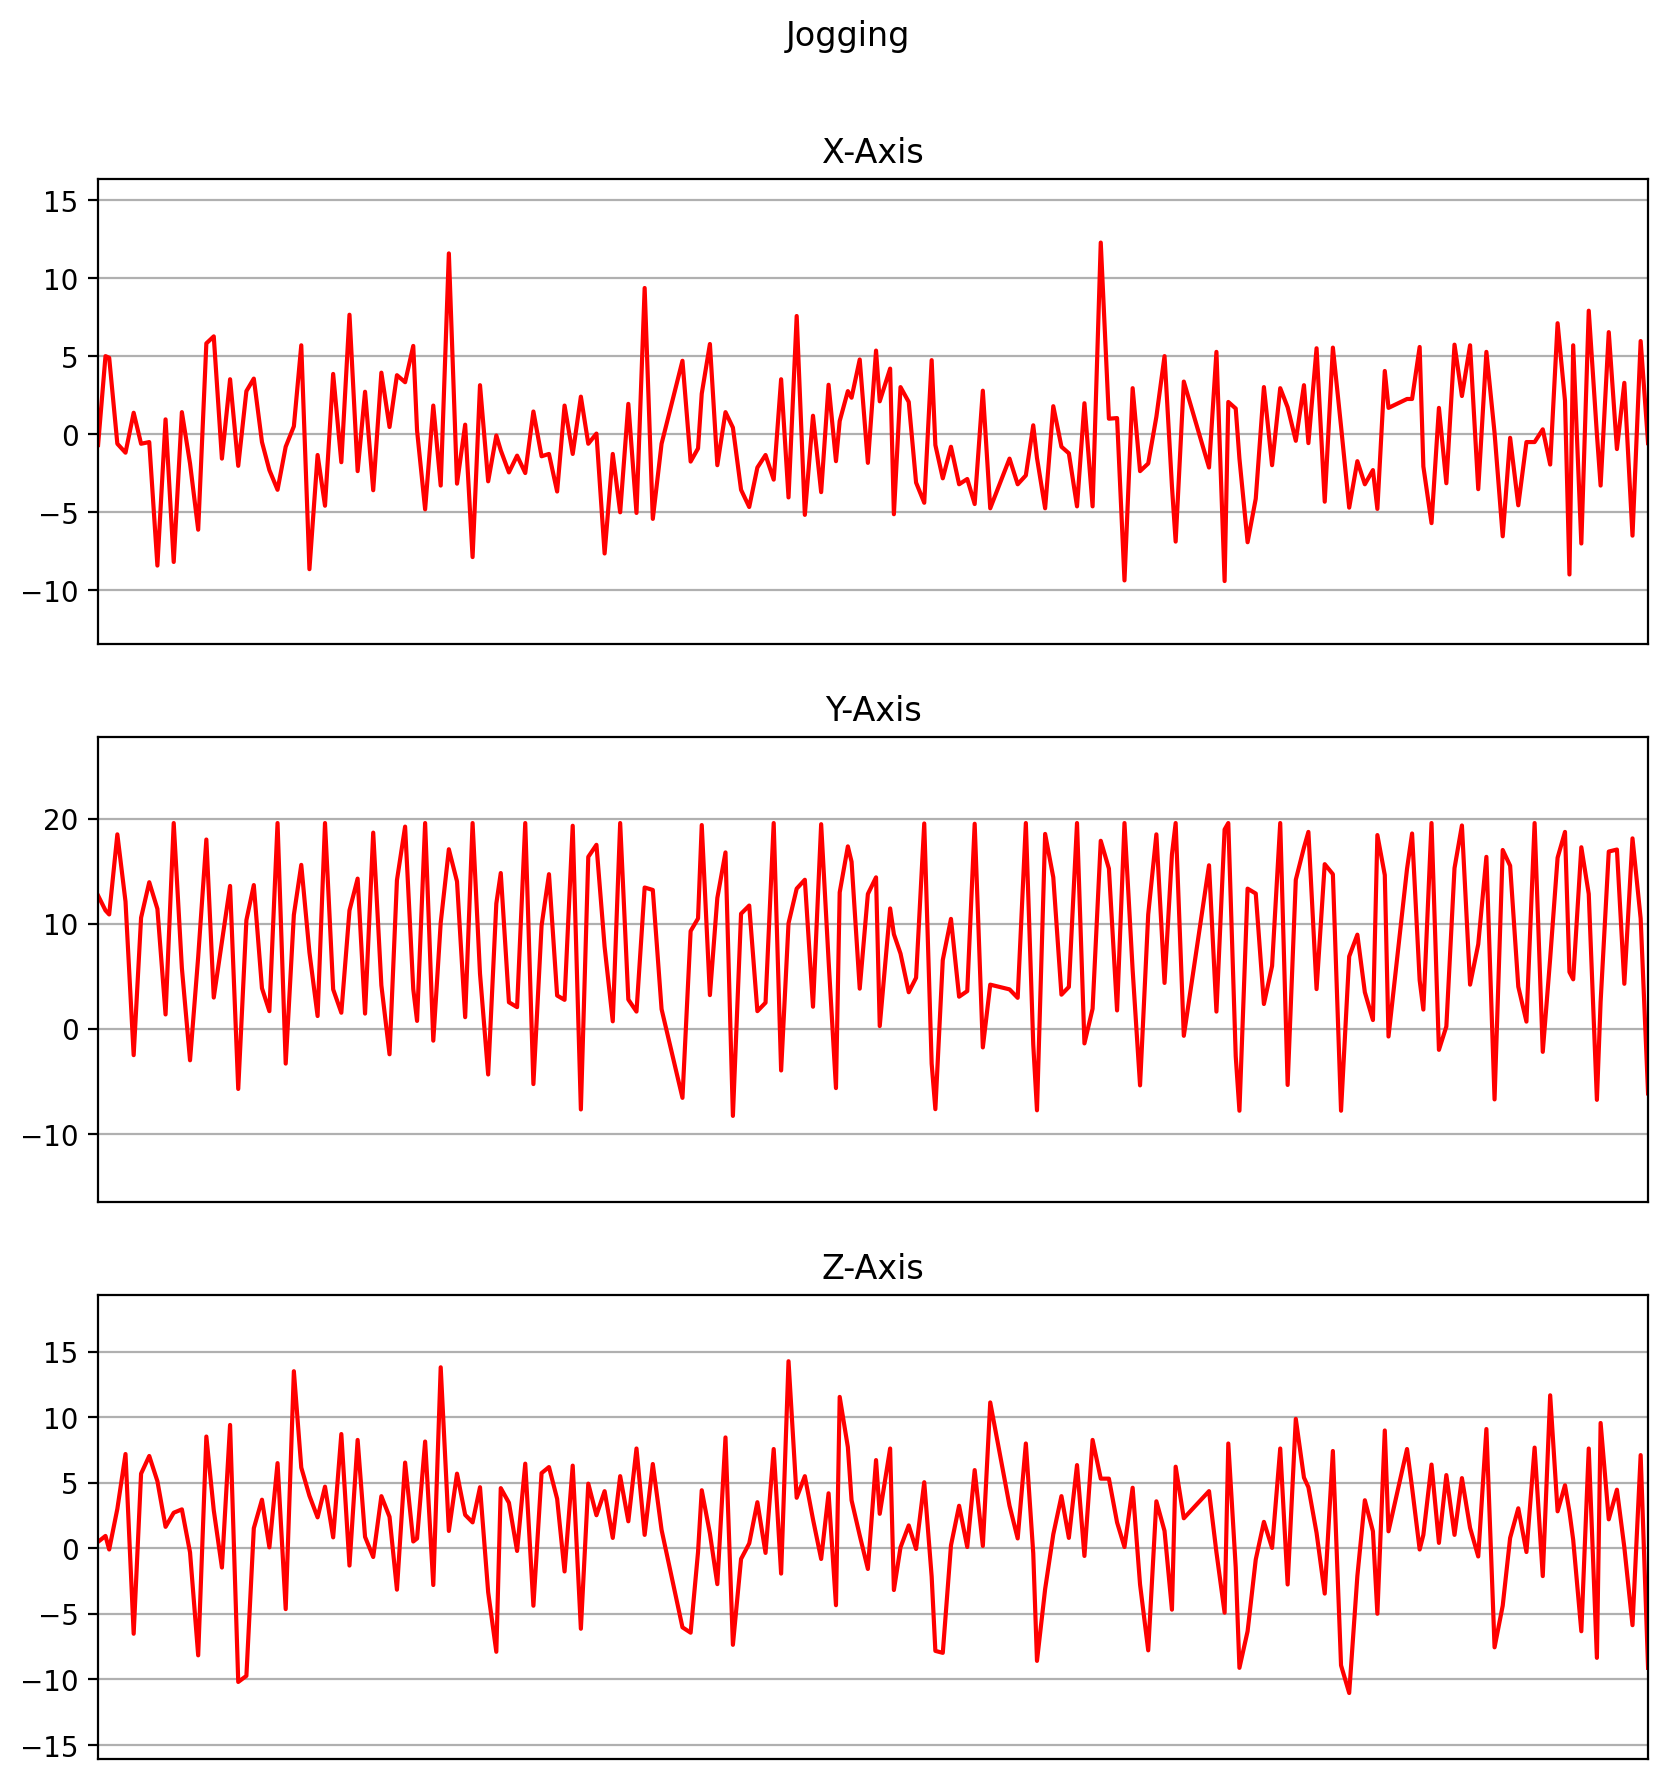

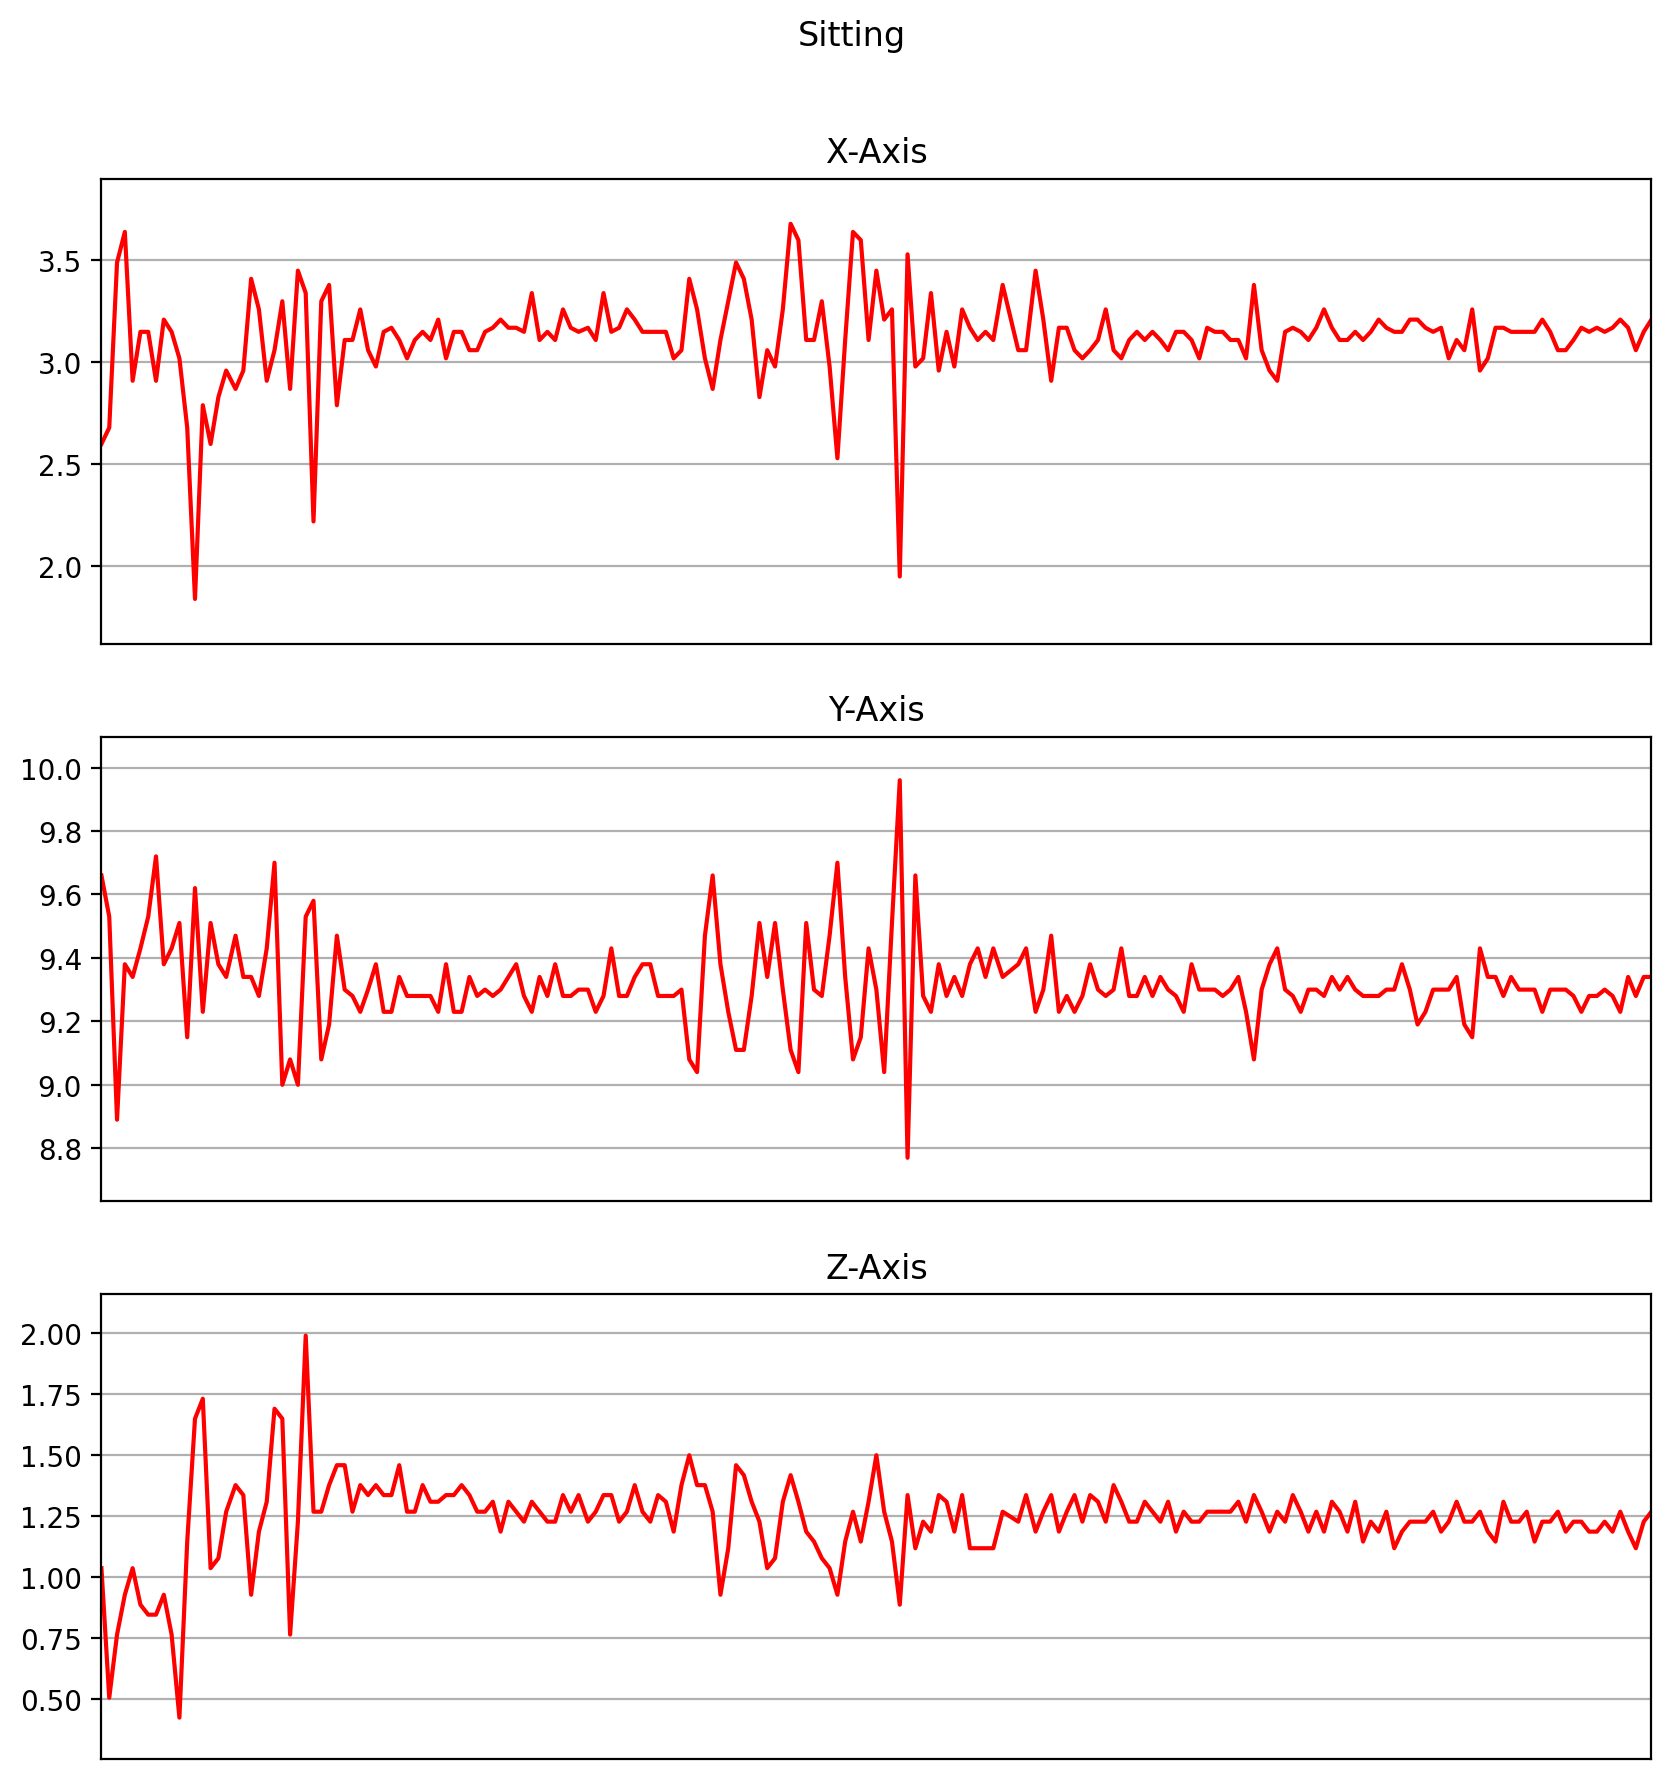

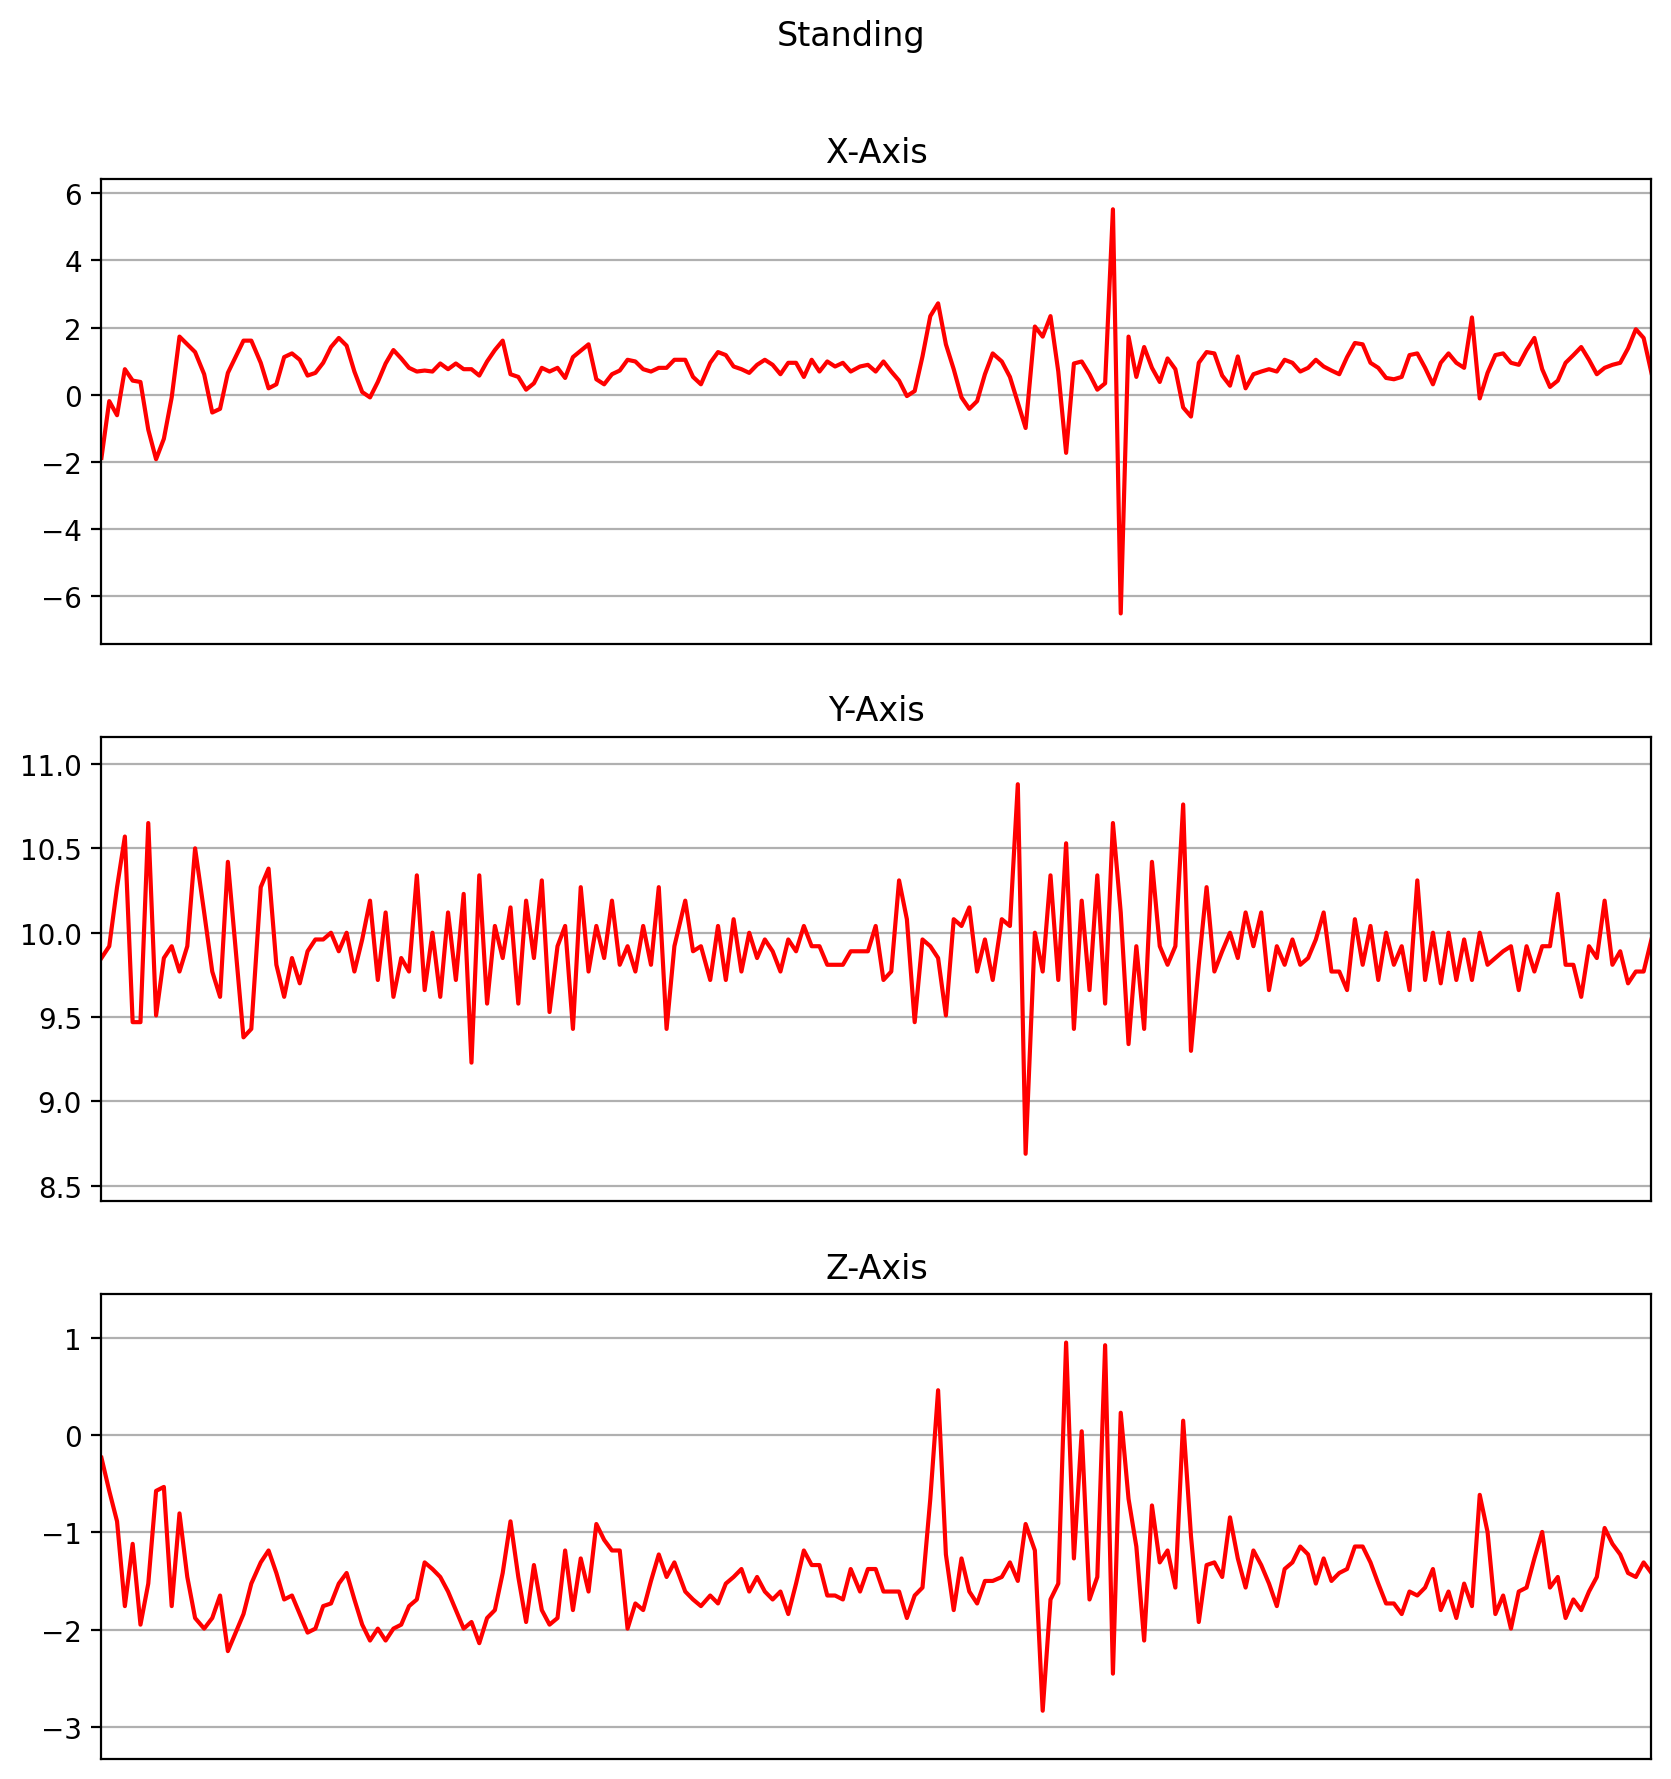

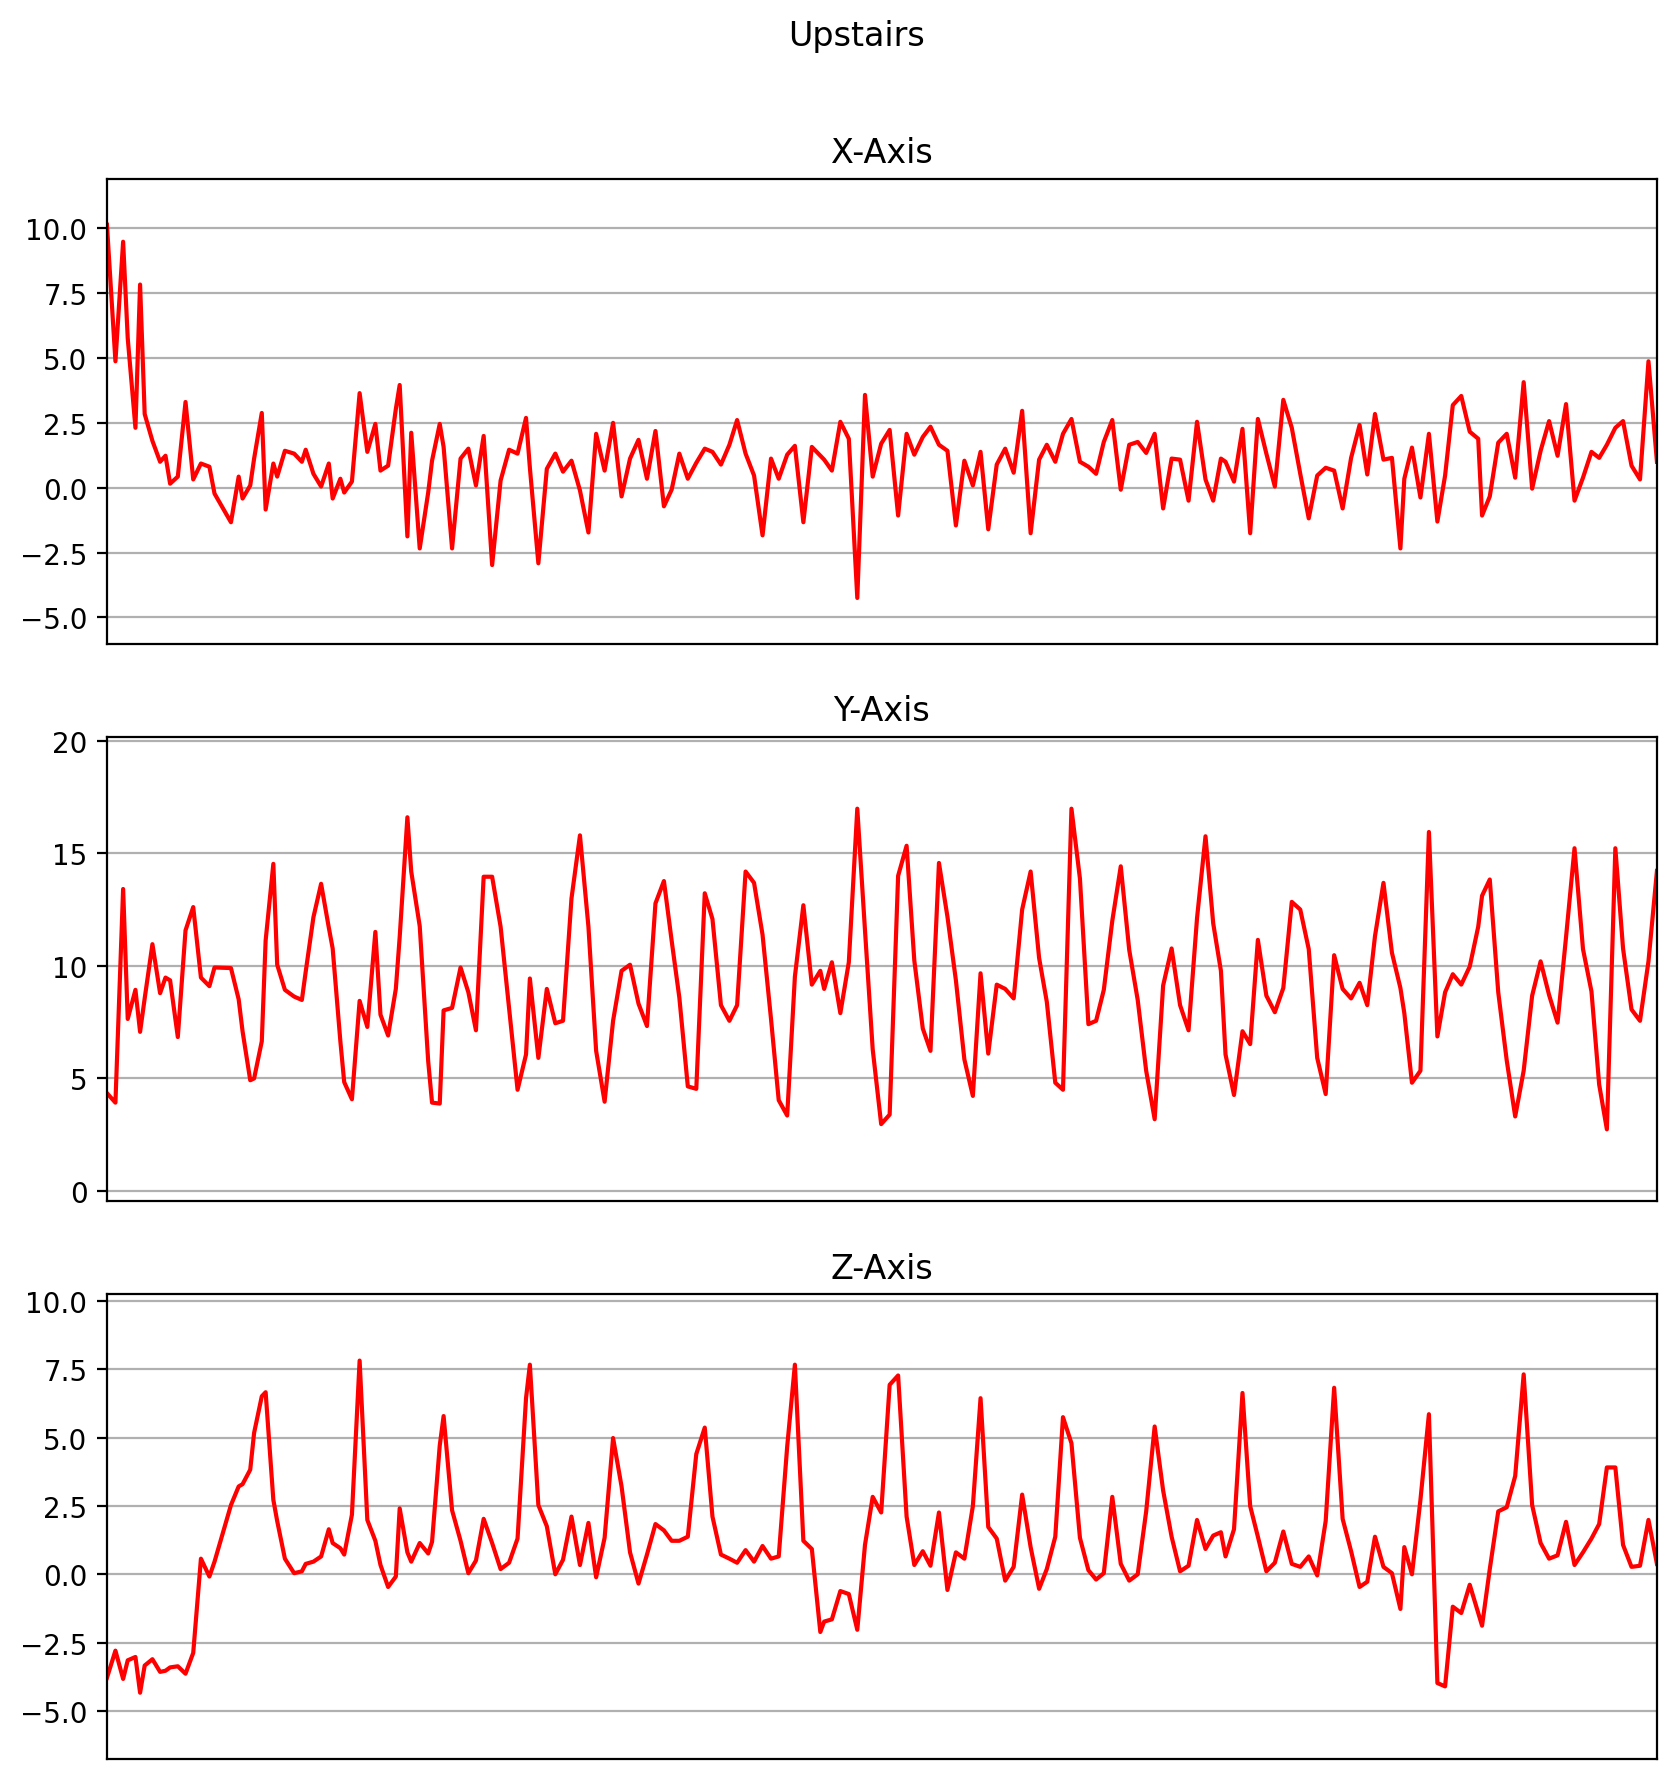

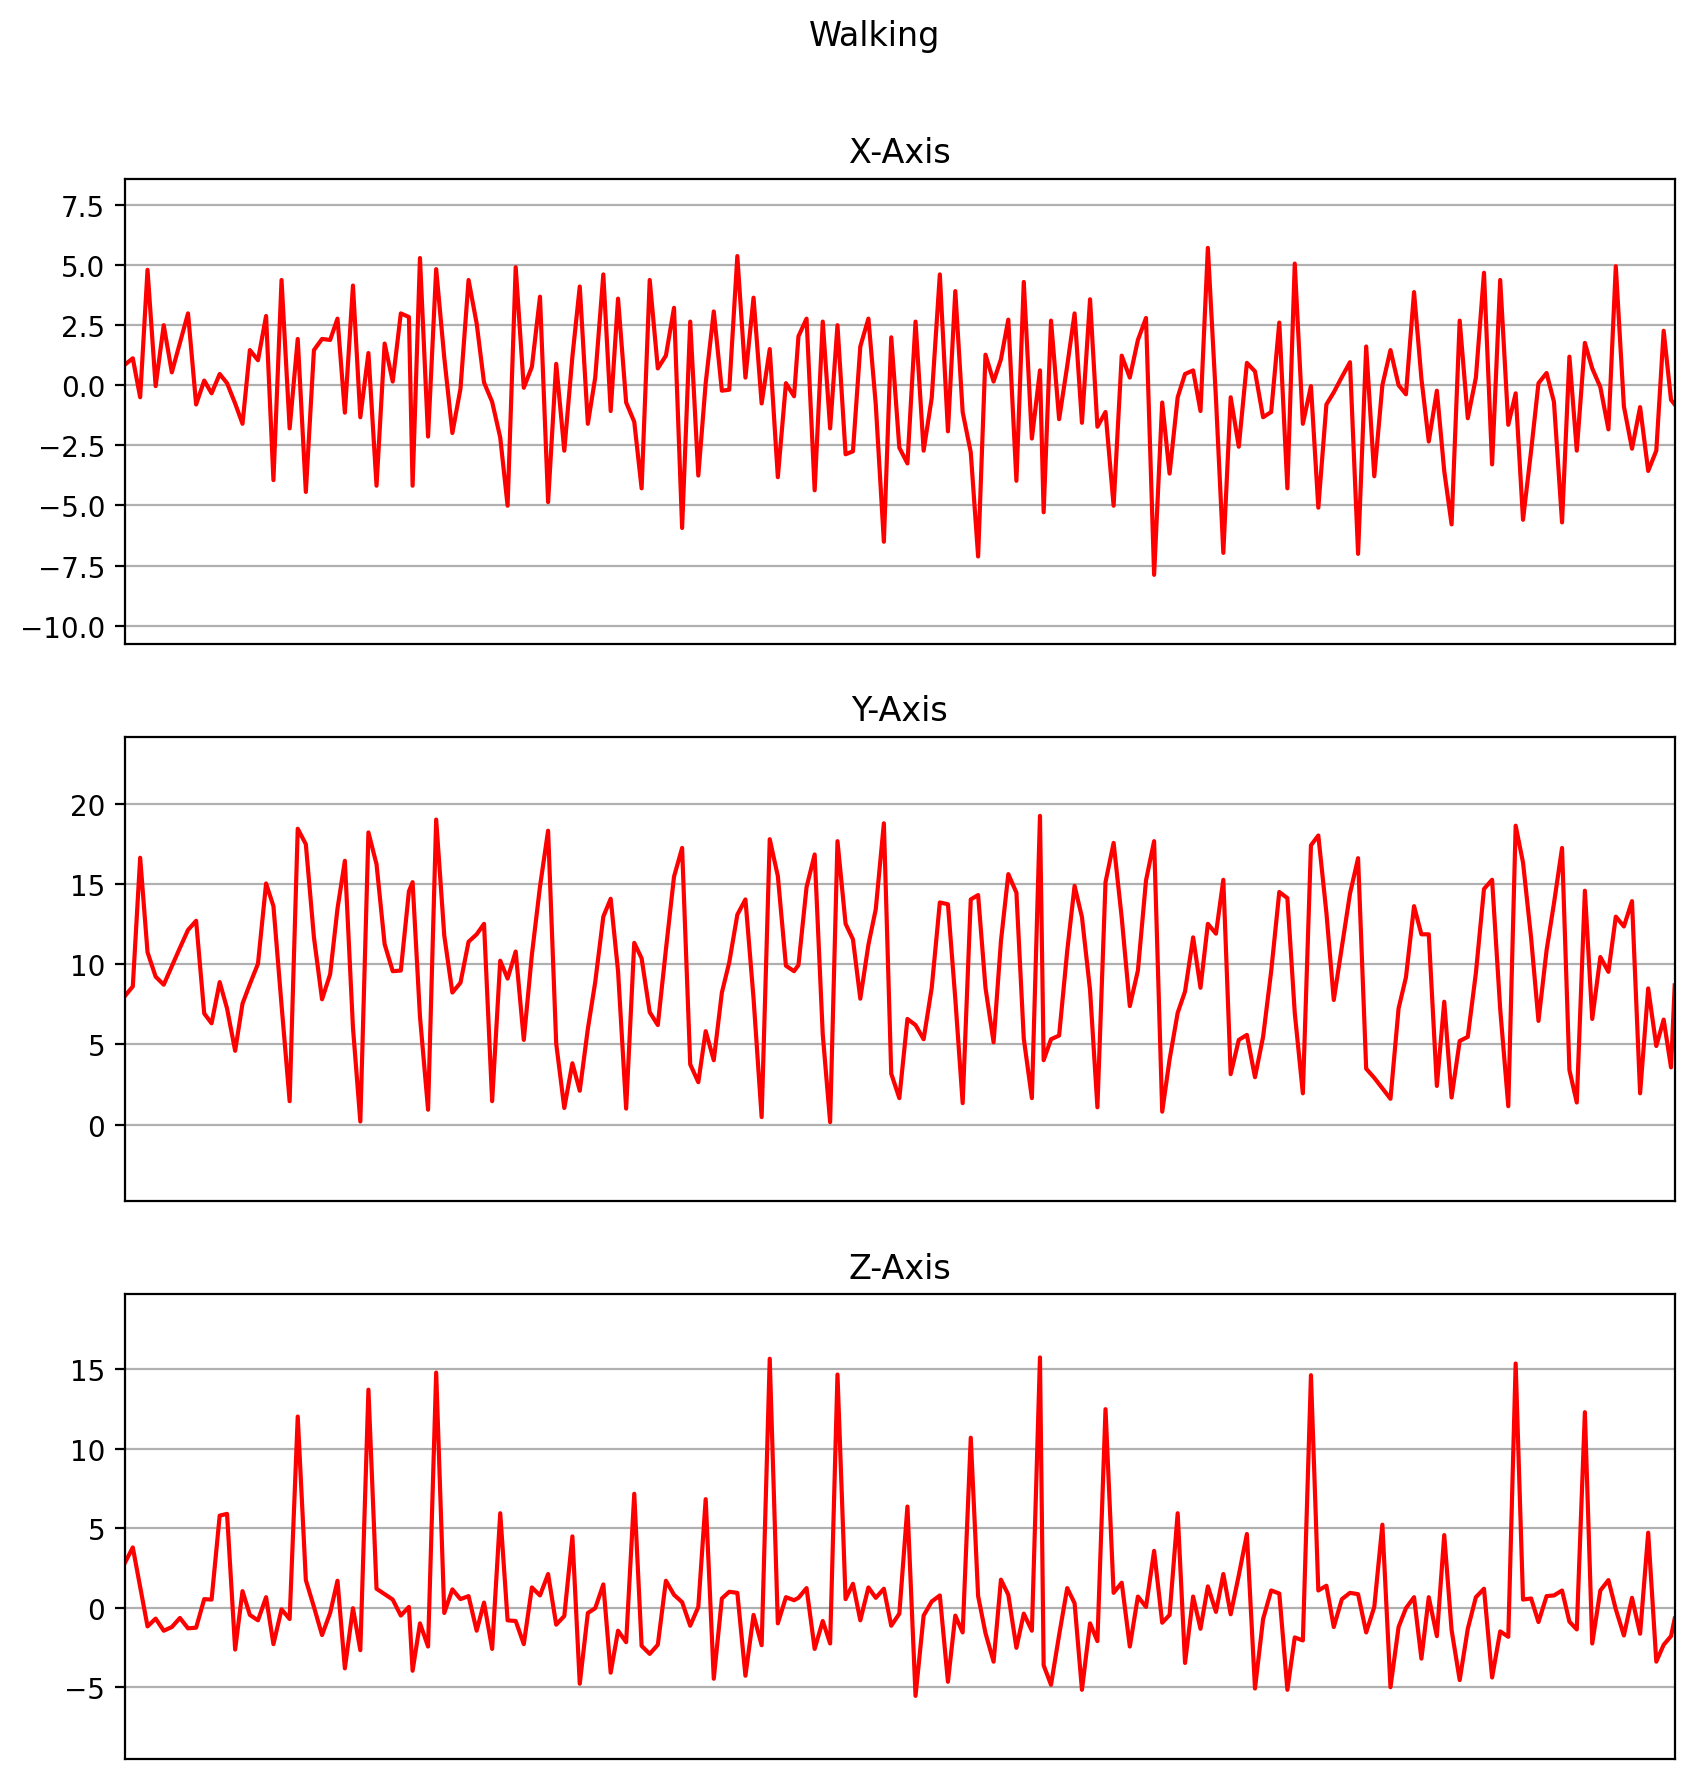

In [19]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:200]
    plot_activity(activity, subset)

In [20]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


# 판독 윈도우 크기 
- 한가지 행동이 일정시간 동안 유지되어야 한다 (윈도우 크기)
- 데이터의 샘플링 간격은 50ms임
- 윈도우 크기를 100으로 잡으면 5초 동안 동일한 행동을 유지하는 경우만 취하게 됨
- stat 모듈이 제공하는 mode() 함수를 사용하여 최빈값을 구하고 이것이 100 인 경우의 데이터만 사용함 (동일한 행동을 5초간 유지하였는지를 파악함)

In [29]:
test = [1,1,1,1,1,1,1,1,1,1,1,1,2,2]
m = stats.mode(test, keepdims=True) # 최빈값
m

ModeResult(mode=array([1]), count=array([12]))

In [26]:
m[1][0]

12

In [27]:
m[0][0], m[1][0]

(1, 12)

In [30]:
z = stats.mode(df['act'][0:100], keepdims=True) # 5초간 관찰
z[0][0], z[1][0]

(1, 100)

## 스케일링

In [31]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [32]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.197590,0.794280,0.021188,1
1,33,Jogging,49106062271000,0.627483,0.583895,0.115037,1
2,33,Jogging,49106112167000,0.611730,0.527252,-0.101100,1
3,33,Jogging,49106222305000,-0.185775,1.658075,0.547311,1
4,33,Jogging,49106332290000,-0.268479,0.709317,1.420390,1


## 훈련-검증 데이터 나누기

- 아래는 임의로 id 번호를 기준으로 훈련-검증 데이터를 나누었다
  - id를 랜덤하게 섞어서 사용자를 선택하려면 random.choice() 사용한다
- 모든 사용자 데이터를 훈련-검증에 포함되게 하려면 전체 데이터를 대상으로 train_test_split()을 사용하면 된다

In [33]:
df_train = df[df['user-id'] < 28]
df_test = df[df['user-id'] >= 28]

In [34]:
(df['user-id'] < 28).mean(), (df['user-id'] >= 28).mean()

(0.7382683047232287, 0.2617316952767713)

## X와 y 준비
- 훈련 및 검증 데이터에 대해서 X와 y를 구하는 함수 정의

In [35]:
def get_xy(N, df): # N: 윈도우 크기 (100)
    X, y = [], []
    for i in range(0, len(df)-N+1, N):
        z = stats.mode(df['act'][i: i+N], keepdims=True)
        action, count = z[0][0], z[1][0]
        if count == N:
            xs = df['x-axis'].values[i: i + N]
            ys = df['y-axis'].values[i: i + N]
            zs = df['z-axis'].values[i: i + N]
            X.append(np.array([xs, ys, zs]).T)
            y.append(action)
    return np.array(X), np.array(y)

In [36]:
N = 100
X_train, y_train = get_xy(N, df_train)
X_test, y_test = get_xy(N, df_test)

In [37]:
X_train.shape, X_test.shape

((7637, 100, 3), (2713, 100, 3))

In [38]:
y_train.shape, y_test.shape

((7637,), (2713,))

## 결과 보기

- 6x6 혼돈 매트릭스를 그려야 한다

In [39]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [40]:
def show_confusion_matrix(y_test, y_pred):
    matrix = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [41]:
def show_results(y_test, y_pred):
    show_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))   

# 선형 분류

In [42]:
lin = SGDClassifier()
lin.fit(X_train.reshape(-1,300), y_train)
lin.score(X_test.reshape(-1,300), y_test)

0.3977147069664578

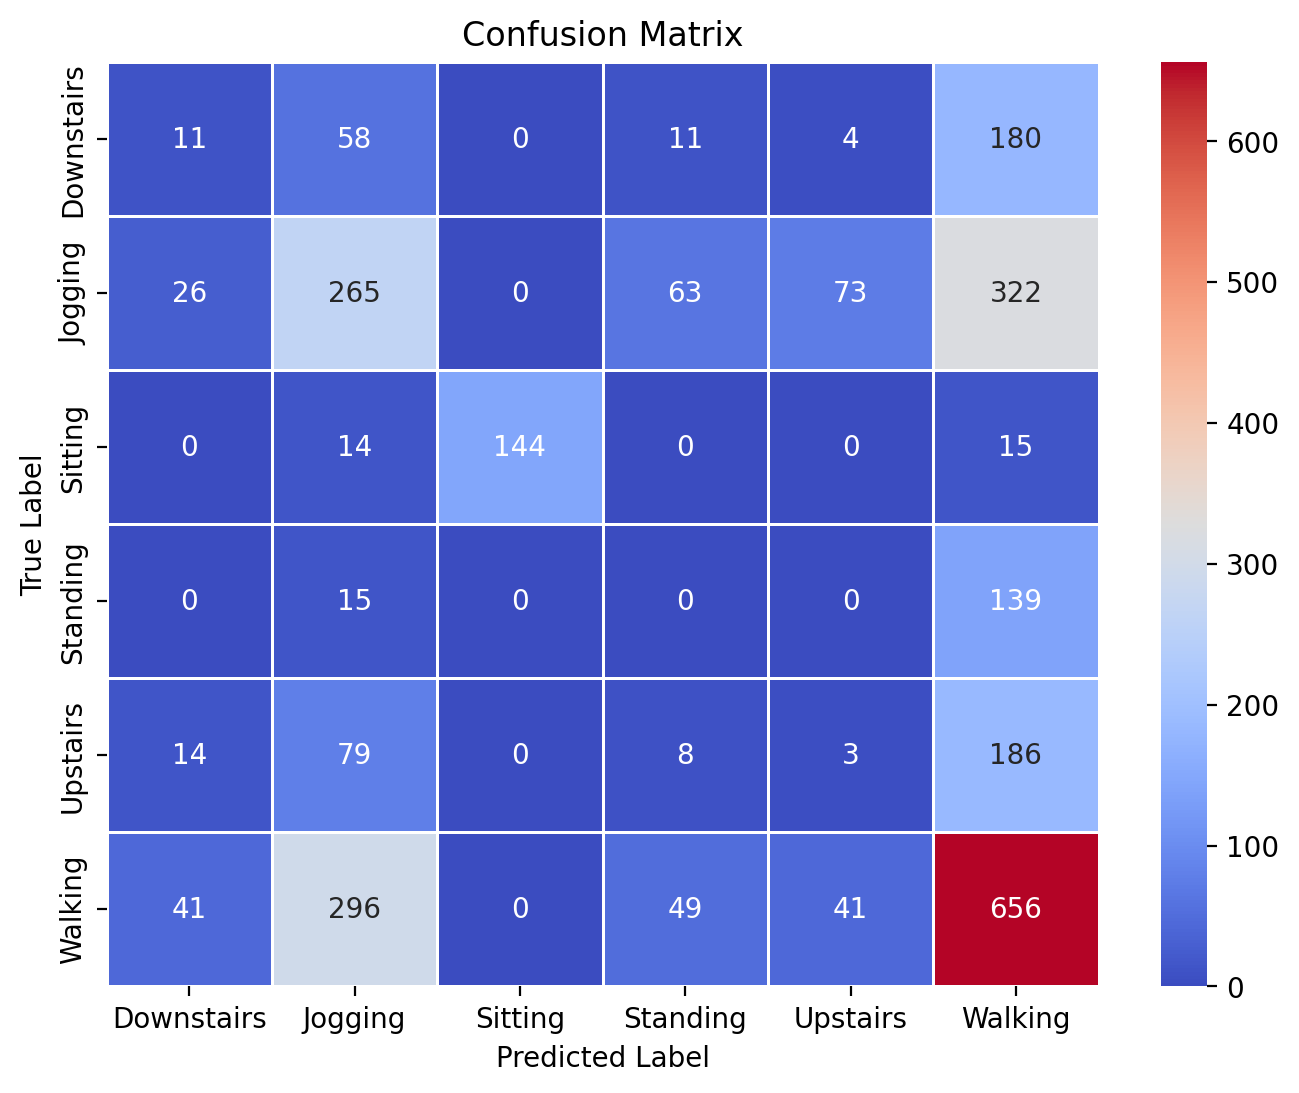

              precision    recall  f1-score   support

           0       0.12      0.04      0.06       264
           1       0.36      0.35      0.36       749
           2       1.00      0.83      0.91       173
           3       0.00      0.00      0.00       154
           4       0.02      0.01      0.01       290
           5       0.44      0.61      0.51      1083

    accuracy                           0.40      2713
   macro avg       0.32      0.31      0.31      2713
weighted avg       0.35      0.40      0.37      2713



In [43]:
y_pred = lin.predict(X_test.reshape(-1,300))
show_results(y_test, y_pred)

# 랜덤 포레스트

In [44]:
rfc = RandomForestClassifier() 
rfc.fit(X_train.reshape(-1,300), y_train)
rfc.score(X_test.reshape(-1,300), y_test)

0.7427202359012164

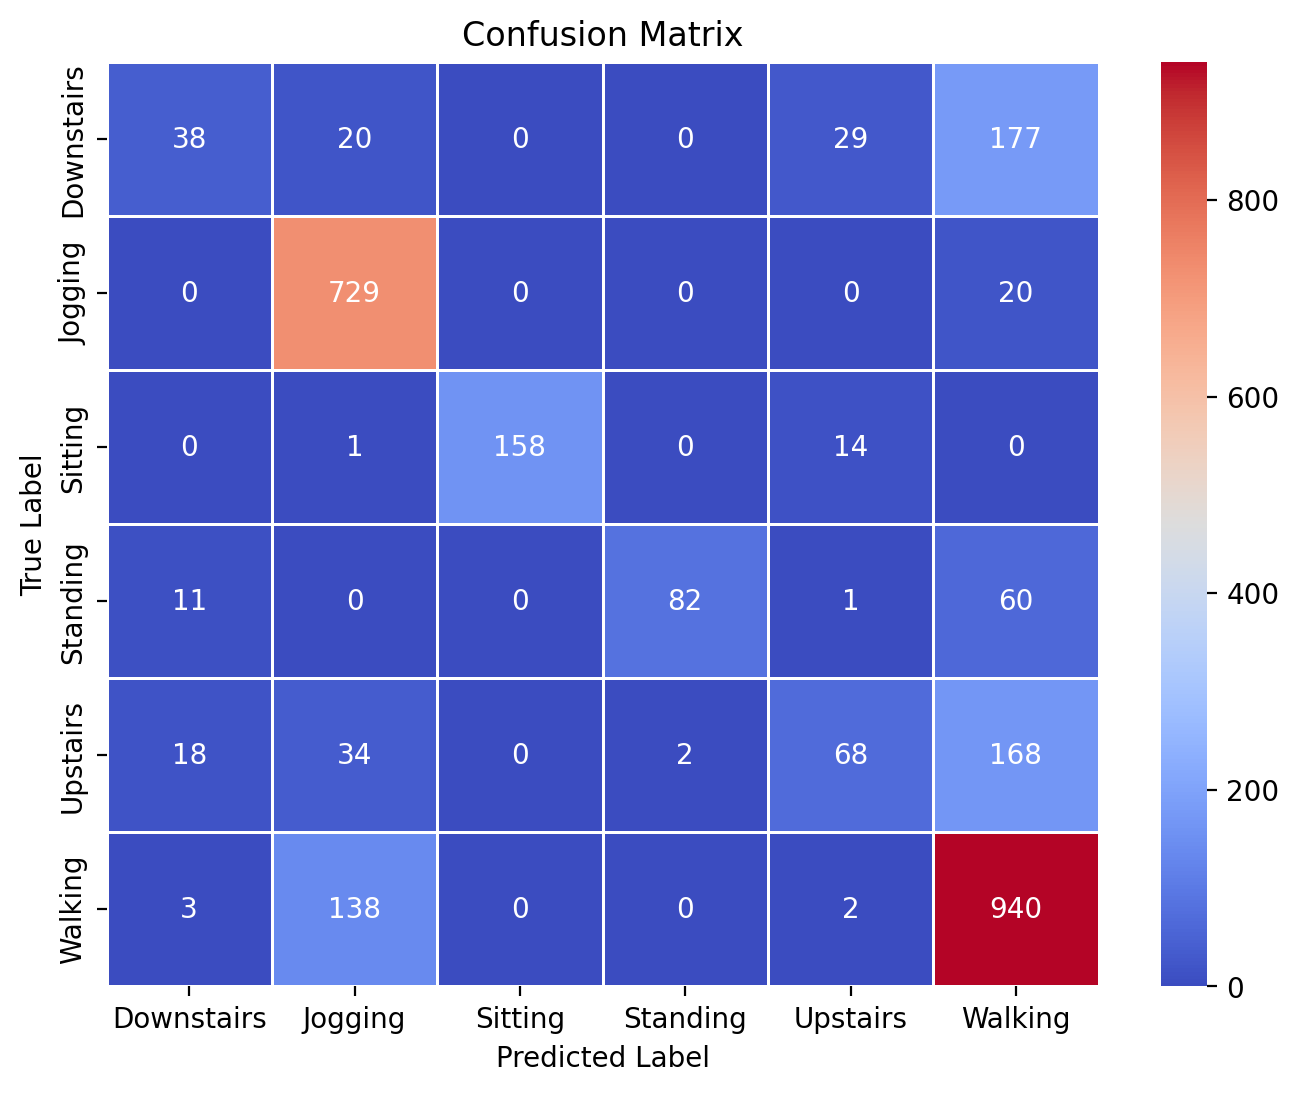

              precision    recall  f1-score   support

           0       0.54      0.14      0.23       264
           1       0.79      0.97      0.87       749
           2       1.00      0.91      0.95       173
           3       0.98      0.53      0.69       154
           4       0.60      0.23      0.34       290
           5       0.69      0.87      0.77      1083

    accuracy                           0.74      2713
   macro avg       0.77      0.61      0.64      2713
weighted avg       0.73      0.74      0.71      2713



In [45]:
y_pred = rfc.predict(X_test.reshape(-1,300))
show_results(y_test, y_pred)

# MLP

## 목적변수 원핫 인코딩
- 신경망은 분류시 레이블을 원핫 인코딩해야 한다

In [46]:
# 원 핫 인코딩
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
y_train_cat[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## MLP 모델 정의

In [47]:
model_m = Sequential()
model_m.add(Reshape((N*3,),input_shape=(N,3)))
model_m.add(Dense(200, activation='relu',input_shape=(N*3,)))
model_m.add(Dropout(0.5))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))

In [48]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

h = model_m.fit(X_train,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=0)

85/85 [==============================] - 0s 1ms/step


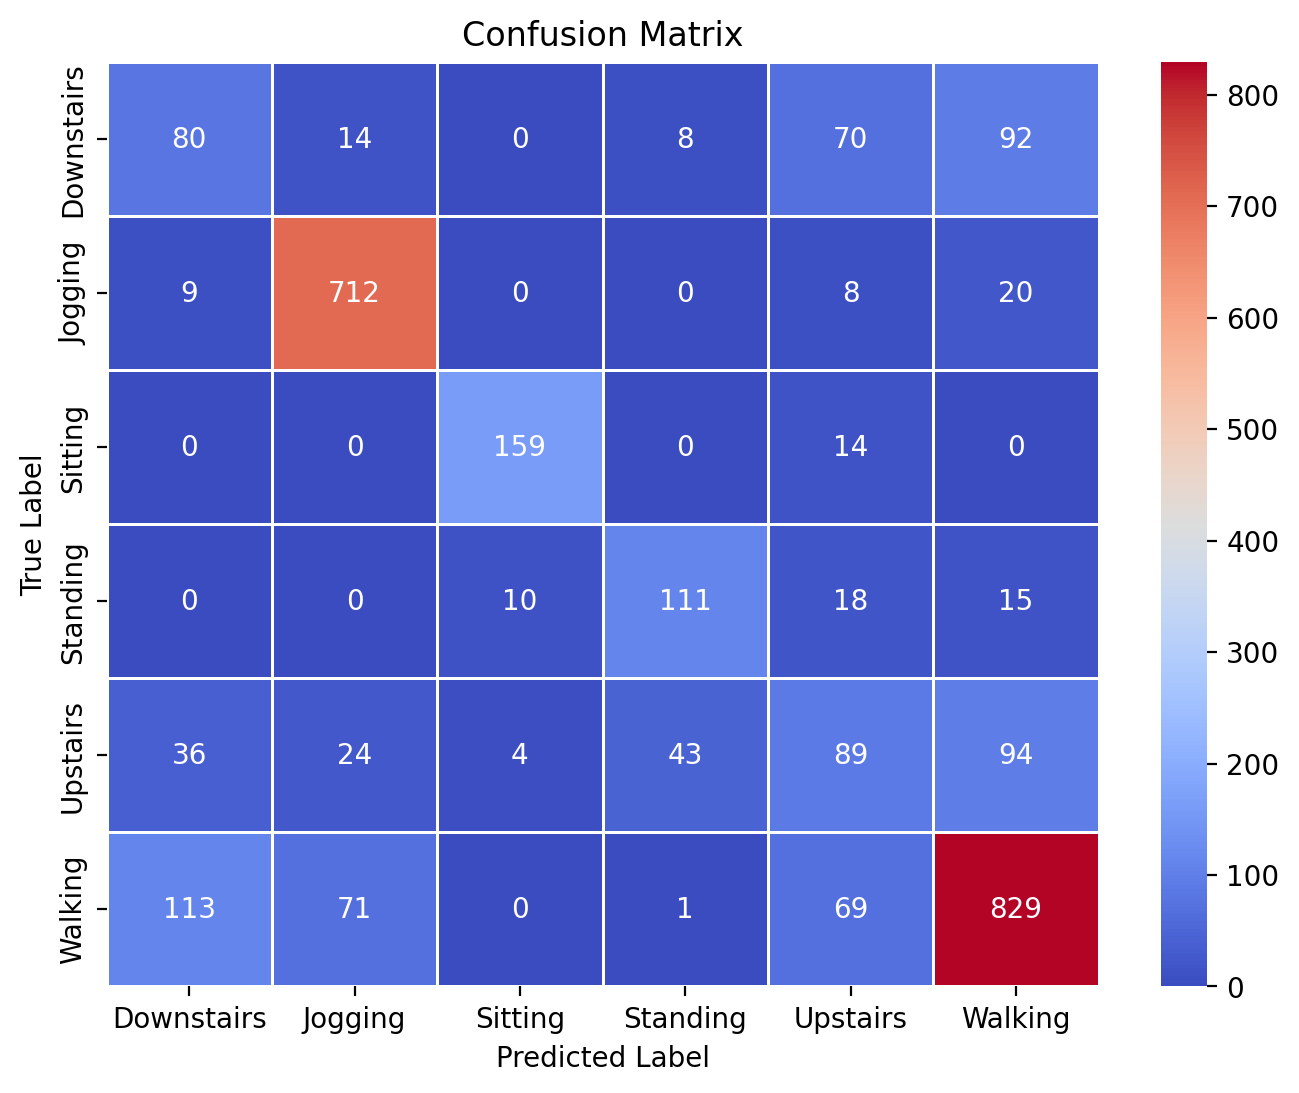

              precision    recall  f1-score   support

           0       0.34      0.30      0.32       264
           1       0.87      0.95      0.91       749
           2       0.92      0.92      0.92       173
           3       0.68      0.72      0.70       154
           4       0.33      0.31      0.32       290
           5       0.79      0.77      0.78      1083

    accuracy                           0.73      2713
   macro avg       0.65      0.66      0.66      2713
weighted avg       0.72      0.73      0.72      2713



In [49]:
y_pred = model_m.predict(X_test)

max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

In [50]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

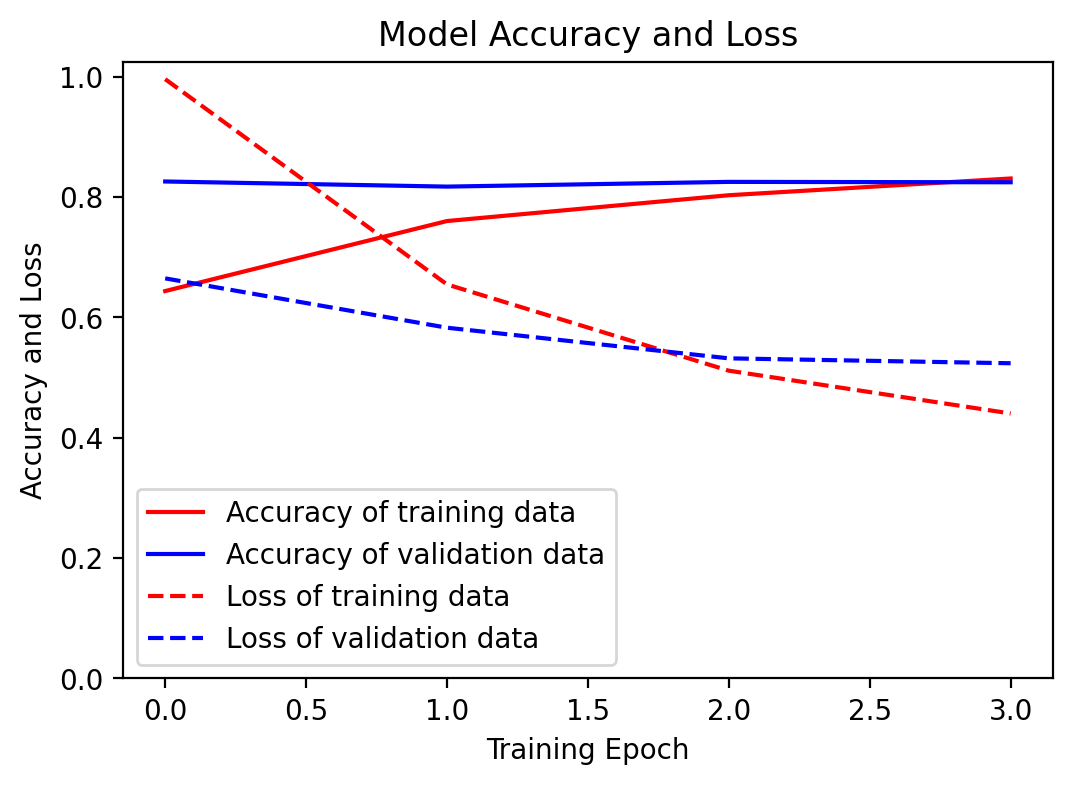

In [51]:
show_4_graphs(h)

# CNN (Conv1D)

- 시계열 패턴 분석에는 1차원 컨볼류션을 사용한다

In [52]:
# (sample, shape, features) 구조 사용, shape=(N,) 인 1차원 어레이
model_cnn = Sequential()
model_cnn.add(Conv1D(32, 4, activation='relu',input_shape=(N,3)))
model_cnn.add(Dropout(0.3))
model_cnn.add(Conv1D(32, 4, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 4, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 4, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(6, activation='softmax'))
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 97, 32)            416       
                                                                 
 dropout_1 (Dropout)         (None, 97, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 32)            4128      
                                                                 
 max_pooling1d (MaxPooling1  (None, 47, 32)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 44, 64)            8256      
                                                                 
 dropout_2 (Dropout)         (None, 44, 64)            0         
                                                      

In [53]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
model_cnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_cnn.fit(X_train,
                      y_train_cat,
                      batch_size=30,
                      epochs=50,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
204/204 [==============================] - 4s 14ms/step - loss: 0.7641 - accuracy: 0.7171 - val_loss: 0.6858 - val_accuracy: 0.7428
Epoch 2/50
204/204 [==============================] - 3s 13ms/step - loss: 0.3602 - accuracy: 0.8617 - val_loss: 0.8908 - val_accuracy: 0.7507
Epoch 3/50
204/204 [==============================] - 3s 14ms/step - loss: 0.2417 - accuracy: 0.9083 - val_loss: 0.7977 - val_accuracy: 0.8122
Epoch 4/50
204/204 [==============================] - 3s 14ms/step - loss: 0.1937 - accuracy: 0.9312 - val_loss: 0.9773 - val_accuracy: 0.7768
Epoch 5/50
204/204 [==============================] - 3s 15ms/step - loss: 0.1505 - accuracy: 0.9463 - val_loss: 0.9044 - val_accuracy: 0.7971
Epoch 6/50
204/204 [==============================] - 3s 13ms/step - loss: 0.1231 - accuracy: 0.9574 - val_loss: 1.0045 - val_accuracy: 0.8037
Epoch 7/50
204/204 [==============================] - 3s 15ms/step - loss: 0.1168 - accuracy: 0.9602 - val_loss: 0.9789 - val_accuracy: 0.8089

85/85 [==============================] - 0s 2ms/step


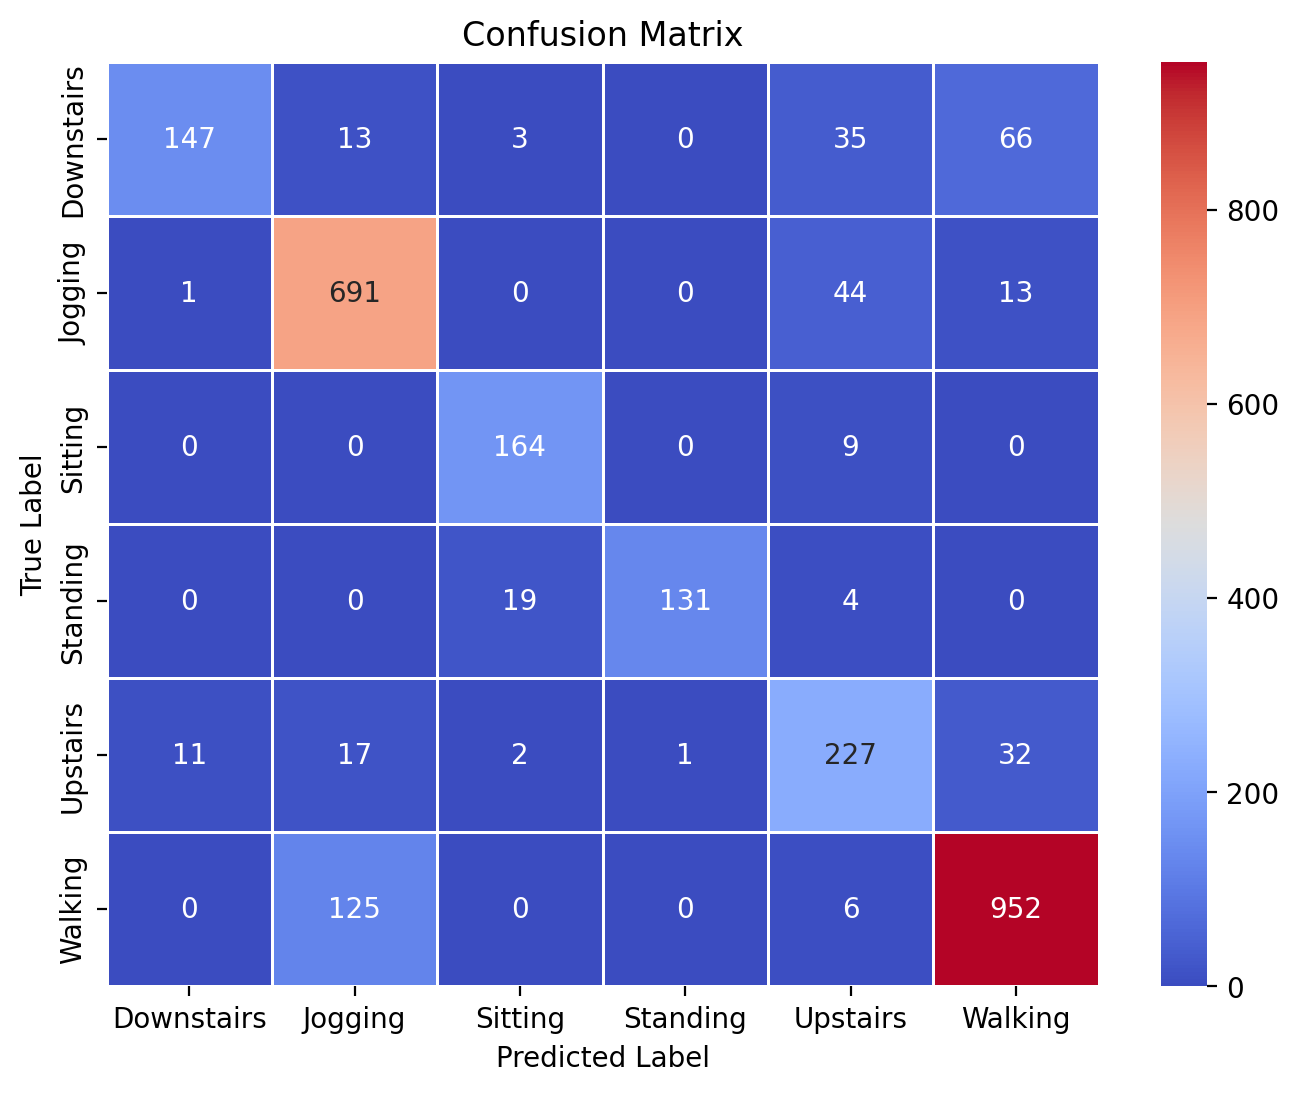

              precision    recall  f1-score   support

           0       0.92      0.56      0.70       264
           1       0.82      0.92      0.87       749
           2       0.87      0.95      0.91       173
           3       0.99      0.85      0.92       154
           4       0.70      0.78      0.74       290
           5       0.90      0.88      0.89      1083

    accuracy                           0.85      2713
   macro avg       0.87      0.82      0.84      2713
weighted avg       0.86      0.85      0.85      2713



In [54]:
y_pred = model_cnn.predict(X_test)

max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

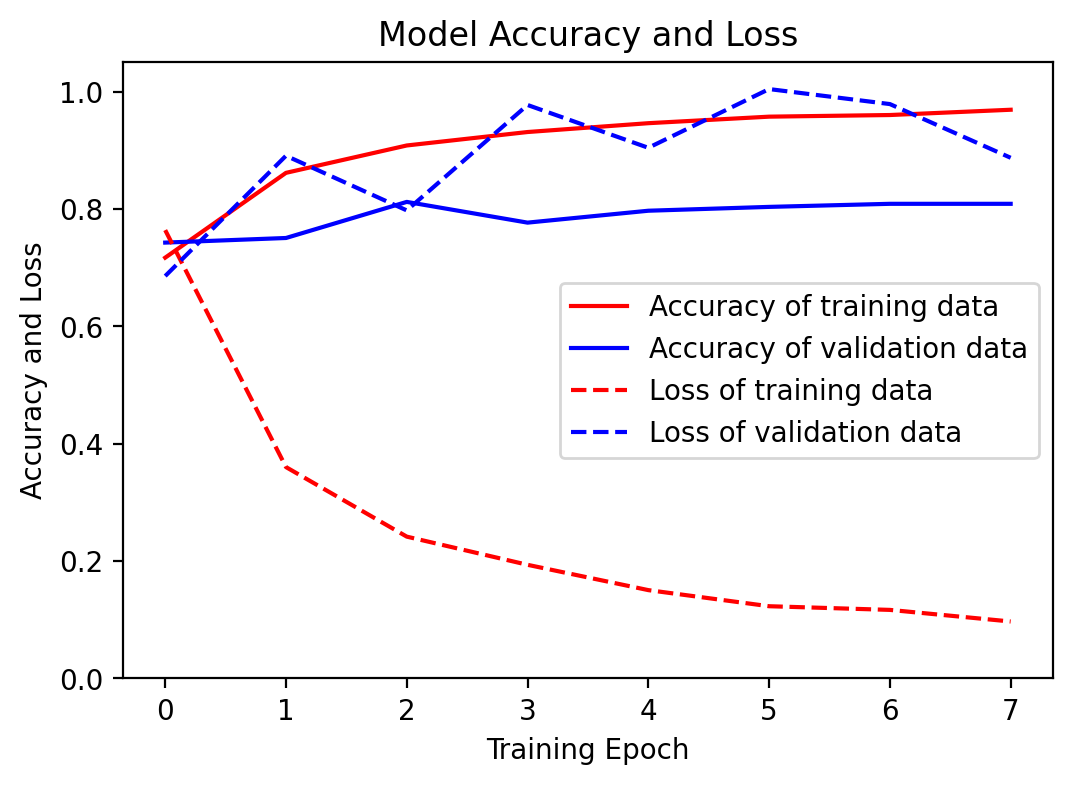

In [55]:
show_4_graphs(history)